## IFPA Antarctica example
This notebook accompanies the manuscript *"Antarctic subglacial topography mapped from space reveals complex mesoscale landscape dynamics"*. 
It provides a short example of how to run the IFPA code over a small region. Note that the code presented here does not include the ice-thickness correction with geophysical observations. 

In [4]:
%%html
<style>
table {align:left;display:block}
</style>

You will need the following packages:

In [5]:
# To load and process data
import geopandas as gpd
import numpy as np
from inversion_module_v3 import terminal_inversion_smooth_frot, smooth_data_load

# For plotting here
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from shapely.geometry import box

You will also need the following datasets:

**Large datasets (save these in a folder called Large_data)**

| Filename      | Description | Reference | DOI |
| :----------- | :----------- | :---------| :------------ |
| GaplessREMA100.nc     | Gapless REMA Antarctica dataset at 100m resolution        | Dong et al. (2022) | 10.1016/j.isprsjprs.2022.01.024|
| GaplessREMA100_its2.nc     | Gapless REMA Antarctica dataset at 450m resolution        | | Can be created using *REMA_on_its.py* |
| BedMachineAntarctica-v3.nc | MEaSURES BedMachine Antarctica bed topography map version 3 | Morlighem et al. (2020) | 10.5067/FPSU0V1MWUB6| 
| antarctic_ice_vel_phase.nc | MEaSURES Antarctic velocity map | Mouginot et al. (2019) | 10.5067/PZ3NJ5RXRH10 |

**Small datasets (save these in a folder called data)**

| Filename      | Description | 
| :----------- | :----------- | 
| Groundingline_Antarctica_v2.shp | Antarctic groundingline shapefile (useful for plotting) |


In [6]:
# Set the filepath to all the small datasets 
data_folder = '../../Data/'
# Set the filepath to all the large datasets 
large_data_folder = '../../Large_data/'
# Set the filepath to where you would like to save outputs
output_folder = '../Notebook_test/'

## Select the data files to be processed
filepath_rema = large_data_folder + 'GaplessREMA100.nc'
filepath_rema_its = large_data_folder + "GaplessREMA100_its2.nc"
filepath_bedmach = large_data_folder + "BedMachineAntarctica-v3.nc"
#filepath_velocity = "antarctica_ice_velocity_450m_v2.nc"
filepath_velocity = large_data_folder + "antarctic_ice_vel_phase.nc" 
# Useful files for plotting
groundinglineM = gpd.read_file(data_folder + "Groundingline_Antarctica_v2.shp")

### Setting parameters and running IFPA 

To describe the region which you would like to apply IFPA to, you will need to provide values for:

* the coordinates of the centre of the region (in Antarctic Polar Stereographic)
* the size of individual patches (square_size, default = 50000 m) 
* the number of overlapping patches (n, default = 3)
* the number of adjacent regions in the x and y directions (adj, default = [6,6])

The resulting region will have dimensions of (adj * square_size)/(2 * n)

In [35]:
## Select the centre coordinate
#centre_coord = [-1.586e6,-0.122e6]                               # PIG hill istar 7
#centre_coord = [-1542249.2233862362, -214786.63862677815]        # PIG 17
#centre_coord = [-1551063.1745184413, -248155.27206390776]        # PIG 18
#centre_coord = [-1.41e6, -0.455e6]                               # Lower thwaites
#centre_coord = [-1.08e6, -0.455e6]                                # WAIS
#centre_coord = [-1.30e6, -0.455e6]                               # Upperish thwaites
#centre_coord = [-1767352.284231, 187790.347215]                  # Ferrigno
#centre_coord = [-1198530, -20920]                                # Lake Elsworth
centre_coord= [0.8e6,-1.8e6]                                     # Wilkes Basin?
centre_coord = [0.9e6, -1.8e6]
## Region to invert over
square_size = 50000                       # In metres
n = 3                                     # Number of overlapping grids
adj = [12,12]                               # Number of adjacent grids

print('The region you have selected has dimensions of {:.0f} by {:.0f} km.\nIt is centred on {:.0f} East, {:.0f} North \
(Antarctic Polar Stereographic Coordinates)'.format(\
        adj[0] * (square_size/(2*n))/1000, adj[1] * (square_size/(2*n))/1000, centre_coord[0], centre_coord[1]))

The region you have selected has dimensions of 100 by 100 km.
It is centred on 900000 East, -1800000 North (Antarctic Polar Stereographic Coordinates)


Additionally, you may specify the physical parameters which you would like for the inversion.

* The sliding law constant (m, default = 1)
* The mean non-dimensional slipperiness (C, default = 50)
* The ice flow perturbation transfer functions (trans_funcs, default = 2003)

There are also some tuneable parameters representing decisions made about the filtering of problematic wavelengths in the least-squares solution:

* Smoothing filters for wavelengths in the least-squares solution (p_b and p_c, defaults = -2)
* Least squares balance between non-dimensionalised velocity and surface data (erB and erC, default = 0.001)
* Angle to flow of features removed in inversion results for topography (cutB, default = 10)
* Angle to flow of features removed in inversion results for slipperiness (cutC, default = 15)
* Wavelength of topographic features removed in inversion results, as a multiple of h_bar (wavcutB, default = 1)
* Wavelength of slipperiness features removed in inversion results, as a multiple of h_bar (wavcutC, default = 2)
* How much to taper the sides of the grid for the Fourier transform (tapering, default = 0.1)

In [36]:
## Physical system properties
m = 1                                     # Sliding law constant
C = 50                                   # Mean slipperiness
trans_funcs = 2003                        # Which version of the transfer functions to use (2003 or 2008)

## Tuneable parameters
p_b = -2                                  # Smooth filter on wavelengths
p_c = -2                                  # Smooth filter on wavelengths
erB = 1 * (10 **(-3))                     # Least squares balance between non-dimensionalised velocity and surface data
erC = 1 * (10 **(-3))                     # Least squares balance between non-dimensionalised velocity and surface data
CutB = 10                                 # Angle to flow of features removed in inversion results
CutC = 15                                 # Angle to flow of features removed in inversion results
wavcutB = 1                               # Factor of h_bar, wavelength of features removed in inversion results
wavcutC = 2                               # Factor of h_bar, wavelength of features removed in inversion results
tapering = 0.1                            # Remove outer XX% due to tapering

## Other parameters, which are relict from previous code and could now be removed 
centre_include = 1                        # How much of the central grid is included 
                                          # (this feature is now not necessary and could be removed)
interp_grid_spacing = 450                 # In metres (should match velocity grid, could be set in code by data if wanted)

Finally, you should specify the filename for the output, which will be saved as a .nc file, in the output folder which you specified earlier

In [37]:
# Set output file name and path for this run
filename_this_run = 'GR_001'              
filename = output_folder + filename_this_run + '.nc'

To run the IFPA code with these parameters, we then simply call the function **terminal_inversion_smooth_frot**. 
If you see the message 'Results saved to file' printed in the output, then the code should have worked.

In [38]:
%%time 
#terminal_inversion_smooth(m, C, p_b, p_c, erB, erC, n, adj, square_size, tapering, centre_include, \
#                              centre_coord, trans_funcs, \
#                                  filepath_itslive, filepath_rema, filepath_bedmach, interp_grid_spacing, \
#                                  CutB, CutC, wavcutC, wavcutB, filename) 
terminal_inversion_smooth_frot(m, C, p_b, p_c, erB, erC, n, adj, square_size, tapering, centre_include, \
                              centre_coord, trans_funcs, \
                                  filepath_velocity, filepath_rema, filepath_rema_its, filepath_bedmach, interp_grid_spacing, \
                                  CutB, CutC, wavcutC, wavcutB, filename)

Starting Inversion now


/Users/ockendeh/Documents/IFPA/Inversion_code/transferfuncs2003.py:22: RuntimeWarning: invalid value encountered in divide
  t27 = ((t1*t6+(1+C+t8*t9)*t5)*m*k)/(m*k*t1*(t5*t6+1+t9*t1)+complex(0,1)*(t6*t3-m)*ca);
/Users/ockendeh/Documents/IFPA/Inversion_code/transferfuncs2003.py:47: RuntimeWarning: invalid value encountered in divide
  t118 = ((complex(0,1)*((3*C*t1*t3-4)*k*t8*C+2*(((4*C+2+t11)*t3+4+4*C)*t7-2*t16)*k)+\
/Users/ockendeh/Documents/IFPA/Inversion_code/transferfuncs2003.py:74: RuntimeWarning: invalid value encountered in divide
  t93 = k*l*(((-t4-4-C)*t3*C*ca+complex(0,1)*(3*t2*t9*t11+2*(4*C+2+t2)*t3-4-4*C)*k)*t18*t20+\
/Users/ockendeh/Documents/IFPA/Inversion_code/transferfuncs2003.py:91: RuntimeWarning: invalid value encountered in divide
  t23 = -C*k*m*t2/(t5*m*k*(t2*t9+1+t11*t5)+complex(0,1)*(t9*t7-m)*ca);
/Users/ockendeh/Documents/IFPA/Inversion_code/transferfuncs2003.py:114: RuntimeWarning: invalid value encountered in divide
  t90 = C*(((t2-2)*t4*ca+complex(0,1)*k*(2*

Ending Inversion now: 54.2269 seconds


/Users/ockendeh/Documents/IFPA/Inversion_code/inversion_module_v3.py:768: RuntimeWarning: invalid value encountered in divide
  big_bed_total = np.sum(big_bed * big_w)/(np.sum(big_w))
/Users/ockendeh/Documents/IFPA/Inversion_code/inversion_module_v3.py:769: RuntimeWarning: invalid value encountered in divide
  big_slip_total = np.sum(big_slip * big_w)/(np.sum(big_w))


Results saved to file
CPU times: user 50.7 s, sys: 3.4 s, total: 54.1 s
Wall time: 54.6 s


### Plotting the results

First, we load in the .nc file which we just created, and extract the bed topography 

In [39]:
output = Dataset(filename,'r',format='netCDF4')
X = output.variables['x'][:]
Y = output.variables['y'][:]
x, y = np.meshgrid(X, Y)
bed = output.variables['bed'][:,:]
errbed_j = output.variables['errbed'][:,:]
#slip_j = output.variables['slip'][:,:]
#errslip_j = output.variables['errslip'][:,:]
output.close()

From this data, we can set the boundaries of the region, and load in the other datasets of interest

In [40]:
bounds = [np.min(x), np.max(x), np.min(y), np.max(y)]
X_its, Y_its, VX, VY, X_rema, Y_rema, SURF, X_bedmach, Y_bedmach, thick, bedmach, errbed, source = \
        smooth_data_load(bounds, filepath_velocity, filepath_rema, filepath_bedmach)

To plot the bed topography and compare it to the topography from BedMachine Antarctica v3

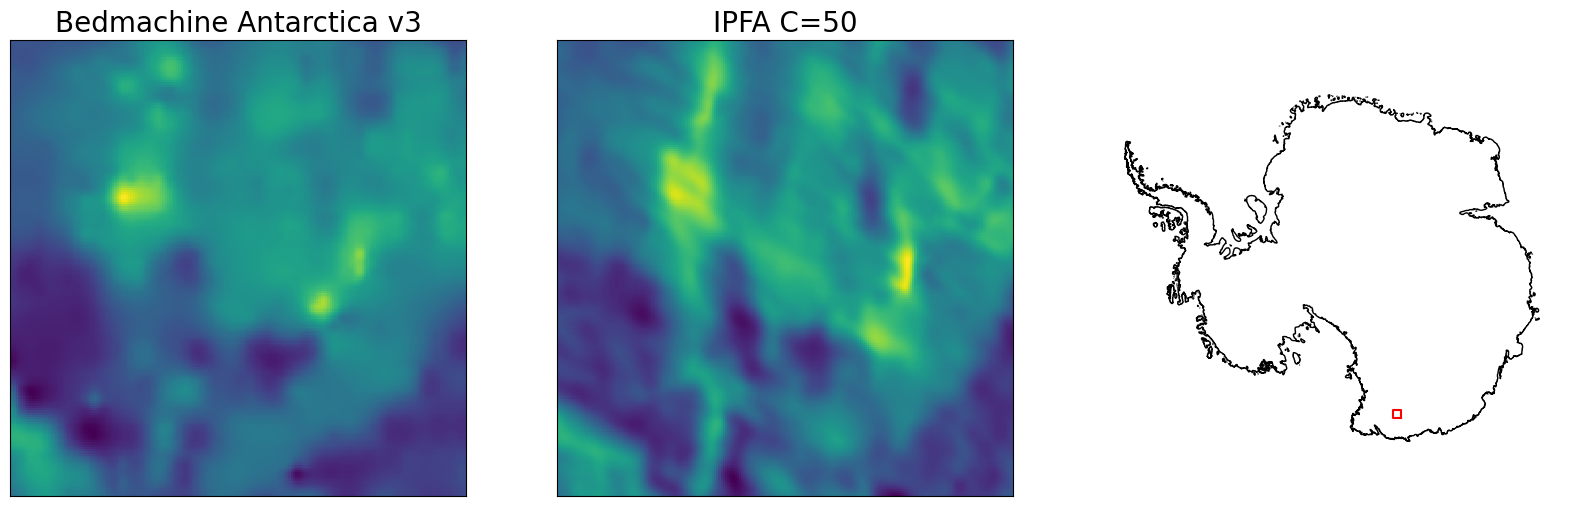

In [41]:
fig, ax = plt.subplots(1,3, figsize = (20,10))
im= [[],[]]
titles = ['Bedmachine Antarctica v3', 'IPFA C={}'.format(C)]
import earthpy.spatial as es
hillshade_on = False
if hillshade_on == True:
    hillshade = es.hillshade(bedmach, altitude = 45, azimuth = 135)
    ax[0].imshow(hillshade, extent = bounds, cmap = 'Greys', zorder = 0, origin = 'upper')
    im[0] = ax[0].imshow(bedmach, extent = bounds, alpha = 0.8, cmap = 'viridis', origin = 'upper')
    hillshade = es.hillshade(bed, altitude = 45, azimuth = 135)
    ax[1].imshow(hillshade, extent = bounds, cmap = 'Greys', zorder = 0, origin = 'lower')
    im[1] = ax[1].imshow(bed, extent = bounds, zorder = 1, alpha = 0.8, origin = 'lower')
else:
    im[0] = ax[0].pcolor(X_bedmach, Y_bedmach, bedmach)
    im[1] = ax[1].pcolor(x, y, bed)
geom = box(bounds[0], bounds[2], bounds[1], bounds[3])
ax[2].plot(*geom.exterior.xy, color = 'r')
ax[2].axis('off')
for i in range(3):
    groundinglineM.plot(ax = ax[i], facecolor = 'None', edgecolor='k', zorder = 0)
    ax[i].get_xaxis().set_ticks([]); ax[i].get_yaxis().set_ticks([]);   
for i in range(2):
    ax[i].set_title(titles[i], fontsize = 20)
    ax[i].set_xlim(bounds[0], bounds[1])
    ax[i].set_ylim(bounds[2], bounds[3])

fig.savefig(output_folder + 'Bed_topography_'+filename_this_run+'.jpg', bbox_inches = 'tight', dpi = 200)

### The IFPA methodology for a single patch

Here, we look at how the IFPA methodology works when applied to just one patch (with the size and location of the patch as specified at the beginning of this notebook). This is what the function **bed_conditions_frot3** does. 

In [11]:
from inversion_module_v3 import smooth_data_load_rema_its, filter, calcLM_KK
from scipy.fft import fft2, ifft2
# Load in the specified version of the transfer functions 
if trans_funcs == 2008:
    from transferfuncs2008 import Tsb, Tub, Tvb, Tsc, Tuc, Tvc
elif trans_funcs == 2003:
    from transferfuncs2003 import Tsb, Tub, Tvb, Tsc, Tuc, Tvc
else:
    print('Error in transfer functions requested in bed_conditions_clean')

First, we load in the ice surface data in the region of interest

In [12]:
# From the central coordinate, create the boundaries of data to look at
# But since there's no interpolation this is the only grid we need 
bounds = [centre_coord[0]-(square_size/2), centre_coord[0]+(square_size/2), 
      centre_coord[1]-(square_size/2), centre_coord[1] + (square_size/2)]
big_bounds = [centre_coord[0]-(square_size/1.5), centre_coord[0]+(square_size/1.5), 
          centre_coord[1]-(square_size/1.5), centre_coord[1] + (square_size/1.5)]
# Load in the data in one region of interest
X_its, Y_its, VX, VY, _, _, _, X_bedmach, Y_bedmach, thick, bed, errbed, source = \
    smooth_data_load(bounds, filepath_velocity, filepath_rema, filepath_bedmach)
X_rema, Y_rema, SURF =  \
    smooth_data_load_rema_its(bounds, filepath_rema_its)

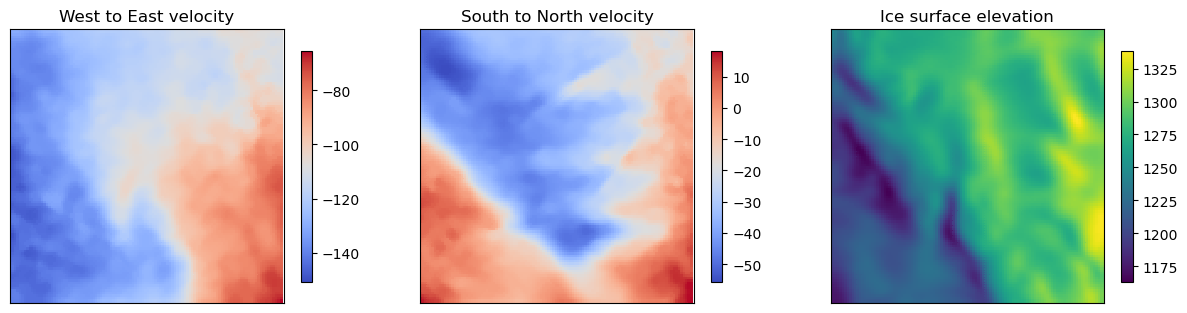

In [13]:
fig, ax = plt.subplots(1,3,figsize = (15,5))
im = [[],[],[]]
titles = ['West to East velocity', 'South to North velocity', 'Ice surface elevation']
im[0] = ax[0].pcolor(X_its, Y_its, VX, cmap = 'coolwarm')
im[1] = ax[1].pcolor(X_its, Y_its, VY, cmap = 'coolwarm')
im[2] = ax[2].pcolor(X_rema, Y_rema, SURF)
for i in range(3):
    plt.colorbar(im[i], ax = ax[i], shrink = 0.6)
    ax[i].set_title(titles[i], fontsize = 12)
    groundinglineM.plot(ax = ax[i], facecolor = 'None', edgecolor='k', zorder = 0)
    ax[i].get_xaxis().set_ticks([]); ax[i].get_yaxis().set_ticks([]);   
    ax[i].set_xlim(bounds[0], bounds[1])
    ax[i].set_ylim(bounds[2], bounds[3])

To apply IFPA, we need the ice velocities *u* and *v*, which are the velocity aligned in the direction of flow, and the velocity perpendicular to the direction of the flow respectively. We also need the perturbations in ice surface relative to the reference planar slab.

In [14]:
## Calculating the angle of slope and correcting the ice surface for this region of interest
# To calculate the mean slope across the patch
xs = np.ndarray.flatten(X_rema[::,::])
ys = np.ndarray.flatten(Y_rema[::,::])
zs = np.ndarray.flatten(SURF[::, ::])
# Using matrix algebra to fit a plane to the 3D data
tmp_A = []
tmp_b = []
for i in range(len(xs)):
    tmp_A.append([xs[i], ys[i], 1])
    tmp_b.append(zs[i])
b = np.matrix(tmp_b).T
A = np.matrix(tmp_A)
fit = (A.T * A).I * A.T * b
alpha_s = np.array((fit[0]**2 + fit[1] **2)/ (np.sqrt((fit[0]**2 + fit[1] **2))))
angle = -(np.arctan2(fit[1],fit[0]) *180/np.pi)
# Calculate the mean ice thickness in this region
#     h_bar = np.mean(thick) # Mean ice thickness
#     print('whole h_bar')
low_frac = (2*n -1)/(4*n)
high_frac = (2*n +1)/(4*n)
x_low = int(np.round(low_frac * X_bedmach.shape[1]))
x_high = int(np.round(high_frac * X_bedmach.shape[1]))
y_low = int(np.round(low_frac * Y_bedmach.shape[1]))
y_high = int(np.round(high_frac * Y_bedmach.shape[1]))
h_bar = np.mean(thick[y_low:y_high, x_low:x_high])

# Remove the surface slope from the surface data
SLOPE_its = X_rema * np.array(fit[0]) + Y_rema * np.array(fit[1]) + np.array(fit[2])
SURF_interp = SURF - SLOPE_its

# Recalculate the velocity fields so that VX is the speed in the direction of flow 
ice_speed = np.sqrt(VX**2 + VY**2)
theta = np.arctan2(VY, VX)
ice_direct = np.mean(np.arctan2(VY, VX)) *180/np.pi
VX_rot =  ice_speed * np.cos(theta-(np.array(ice_direct) * np.pi/180))
VY_rot =  ice_speed * np.sin(theta-(np.array(ice_direct) * np.pi/180))

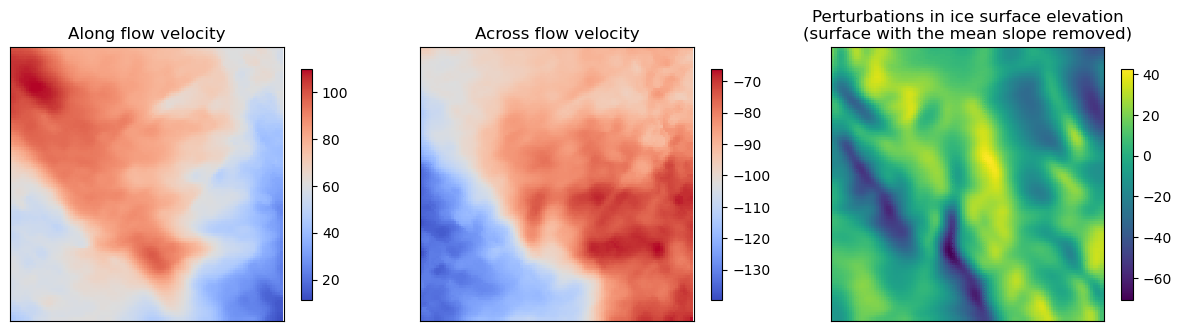

In [15]:
fig, ax = plt.subplots(1,3,figsize = (15,5))
im = [[],[],[]]
titles = ['Along flow velocity', 'Across flow velocity', 'Perturbations in ice surface elevation\n(surface with the mean slope removed)']
im[0] = ax[0].pcolor(X_its, Y_its, VX_rot, cmap = 'coolwarm')
im[1] = ax[1].pcolor(X_its, Y_its, VY_rot, cmap = 'coolwarm')
im[2] = ax[2].pcolor(X_rema, Y_rema, SURF_interp)
for i in range(3):
    plt.colorbar(im[i], ax = ax[i], shrink = 0.6)
    ax[i].set_title(titles[i], fontsize = 12)
    groundinglineM.plot(ax = ax[i], facecolor = 'None', edgecolor='k', zorder = 0)
    ax[i].get_xaxis().set_ticks([]); ax[i].get_yaxis().set_ticks([]);   
    ax[i].set_xlim(bounds[0], bounds[1])
    ax[i].set_ylim(bounds[2], bounds[3])

To apply IFPA to these datasets, we also need to remove the mean to calculate the perturbations to the reference state, and then non-dimensionalise them.

In [16]:
if C == True:
    C = -6.208 * (np.log(h_bar*alpha_s/np.mean(ice_speed))) + 47.644
else:
    None

#h_bar = np.mean(thick)
Ice_speed = np.sqrt(VX**2 + VY**2)
mean_ice_vel = np.mean((Ice_speed))
u_bar = mean_ice_vel
spacing = np.abs(X_its[0,0]-X_its[0,1])
edge_smoothing = ((np.nanmax(Y_its) - np.nanmin(Y_its)) * tapering)
edge_w = int(edge_smoothing/spacing)
tap1 = np.linspace(0,1,edge_w)
tap2x = np.ones(X_its.shape[1]- 2* edge_w)
tap2y = np.ones(X_its.shape[0]- 2* edge_w)
tap3 = np.flip(tap1)
tapx = np.hstack([tap1,tap2x,tap3])
tapy = np.hstack([tap1,tap2y,tap3])
X1, Y1 = np.meshgrid(tapx,tapy)
z = X1*Y1

S_corr = SURF_interp
S_corr = S_corr - np.mean(S_corr)
U_corr = VX_rot - np.mean(VX_rot)
V_corr = VY_rot - np.mean(VY_rot)

# Non dimensionalise and smooth the edges
S_4inv = S_corr / h_bar * z
S_4inv = S_4inv - np.mean(S_4inv)
U_4inv = U_corr / u_bar * z
U_4inv = U_4inv - np.mean(U_4inv)
V_4inv = V_corr / u_bar * z
V_4inv = V_4inv - np.mean(V_4inv)

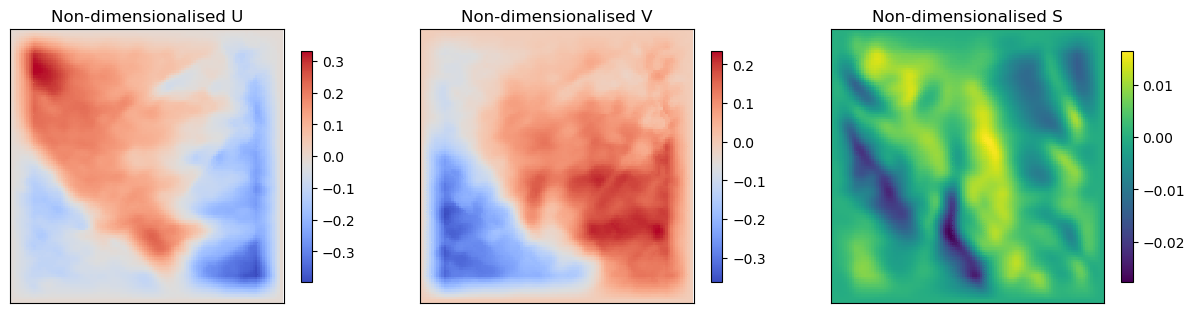

In [17]:
fig, ax = plt.subplots(1,3,figsize = (15,5))
im = [[],[],[]]
titles = ['Non-dimensionalised U', 'Non-dimensionalised V', 'Non-dimensionalised S']
im[0] = ax[0].pcolor(X_its, Y_its, U_4inv, cmap = 'coolwarm')
im[1] = ax[1].pcolor(X_its, Y_its, V_4inv, cmap = 'coolwarm')
im[2] = ax[2].pcolor(X_rema, Y_rema, S_4inv)
for i in range(3):
    plt.colorbar(im[i], ax = ax[i], shrink = 0.6)
    ax[i].set_title(titles[i], fontsize = 12)
    groundinglineM.plot(ax = ax[i], facecolor = 'None', edgecolor='k', zorder = 0)
    ax[i].get_xaxis().set_ticks([]); ax[i].get_yaxis().set_ticks([]);   
    ax[i].set_xlim(bounds[0], bounds[1])
    ax[i].set_ylim(bounds[2], bounds[3])

Then these data are fourier transformed, and the transfer functions are calculated

In [18]:
# Fourier transform
S_ft = fft2(S_4inv)
U_ft = fft2(U_4inv)
V_ft = fft2(V_4inv)
# Create the arrays of k and l for the tranfer functions 
ar1 = np.fft.fftfreq(X_its.shape[1], spacing/h_bar)
ar2 = np.fft.fftfreq(X_its.shape[0], spacing/h_bar)
k,l = np.meshgrid(ar1,ar2)
angle2 = angle
#angle2 = ice_direct
j = np.sqrt( k **2 + l **2)
theta = np.arctan2(l,k) * (180/np.pi)
# Recalculate the transfer functions in the right direction
wave_angle_to_slope = theta - np.array(angle2) 
k_prime = j * np.cos(wave_angle_to_slope * np.pi/180)
l_prime = j * np.sin(wave_angle_to_slope * np.pi/180)
theta_prime = np.arctan2(l_prime,k_prime) * (180/np.pi)

The transfer functions are then applied to the data

In [19]:
# Smoothing the input data and weighting it appropriately
S_filt_ft_b, S_filta_b = filter(p_b, erB, k_prime, l_prime, alpha_s, m, C, S_ft, trans_funcs)
U_filt_ft_b, U_filta_b = filter(p_b, erB, k_prime, l_prime, alpha_s, m, C, U_ft, trans_funcs)
V_filt_ft_b, V_filta_b = filter(p_b, erB, k_prime, l_prime, alpha_s, m, C, V_ft, trans_funcs)
S_filt_ft_c, S_filta_c = filter(p_c, erC, k_prime, l_prime, alpha_s, m, C, S_ft, trans_funcs)
U_filt_ft_c, U_filta_c = filter(p_c, erC, k_prime, l_prime, alpha_s, m, C, U_ft, trans_funcs)
V_filt_ft_c, V_filta_c = filter(p_c, erC, k_prime, l_prime, alpha_s, m, C, V_ft, trans_funcs)
# Calculating the inverse transfer functions
TBS, TBU, TBV = calcLM_KK(erB, k_prime, l_prime, alpha_s, m, C, trans_funcs, rLM_KK = False, BtrueCfalse = True)
TCS, TCU, TCV = calcLM_KK(erC, k_prime, l_prime, alpha_s, m, C, trans_funcs, rLM_KK = False, BtrueCfalse = False)
# Calculating the bed conditions, inverse fourier transform and rescaling
B_ft = TBV * V_filt_ft_b + TBU * U_filt_ft_b + TBS * S_filt_ft_b
C_ft = TCV * V_filt_ft_c + TCU * U_filt_ft_c + TCS * S_filt_ft_c
B_ft[np.isnan(B_ft) ==True ] = 0
C_ft[np.isnan(C_ft) ==True ] = 0

/Users/ockendeh/Documents/IFPA/Inversion_code/transferfuncs2003.py:22: RuntimeWarning: invalid value encountered in divide
  t27 = ((t1*t6+(1+C+t8*t9)*t5)*m*k)/(m*k*t1*(t5*t6+1+t9*t1)+complex(0,1)*(t6*t3-m)*ca);
/Users/ockendeh/Documents/IFPA/Inversion_code/transferfuncs2003.py:47: RuntimeWarning: invalid value encountered in divide
  t118 = ((complex(0,1)*((3*C*t1*t3-4)*k*t8*C+2*(((4*C+2+t11)*t3+4+4*C)*t7-2*t16)*k)+\
/Users/ockendeh/Documents/IFPA/Inversion_code/transferfuncs2003.py:74: RuntimeWarning: invalid value encountered in divide
  t93 = k*l*(((-t4-4-C)*t3*C*ca+complex(0,1)*(3*t2*t9*t11+2*(4*C+2+t2)*t3-4-4*C)*k)*t18*t20+\
/Users/ockendeh/Documents/IFPA/Inversion_code/transferfuncs2003.py:91: RuntimeWarning: invalid value encountered in divide
  t23 = -C*k*m*t2/(t5*m*k*(t2*t9+1+t11*t5)+complex(0,1)*(t9*t7-m)*ca);
/Users/ockendeh/Documents/IFPA/Inversion_code/transferfuncs2003.py:114: RuntimeWarning: invalid value encountered in divide
  t90 = C*(((t2-2)*t4*ca+complex(0,1)*k*(2*

And the resulting bed topography and slipperiness datasets are filtered to remove problematic wavelengths

In [20]:
CutC2 = CutC * np.pi/180
maskCutC = (np.abs(theta) < (CutC2 + np.pi/2)) & (np.abs(theta) > (np.pi/2 - CutC2))
maskCutC2 = (np.abs(theta) < CutC2) + (np.abs(theta) > (np.pi - CutC2))
C_ft[maskCutC + maskCutC2] = 0
maskwavcutC = ((1/j)*h_bar) <  wavcutC * h_bar
C_ft[maskwavcutC] = 0

theta = np.arctan2(l_prime,k_prime)
theta2 = theta * (-np.cos((theta/CutB) * np.pi) + 1)/2
CutB2 = CutB * np.pi/180
mask = (np.abs(theta) < (CutB2 + np.pi/2)) & (np.abs(theta) > (np.pi/2 - CutB2))
maskand = (np.abs(theta) < CutB2) + (np.abs(theta) > (np.pi - CutB2))
B_ft[mask] = B_ft[mask] * theta2[mask]

B_ift = (ifft2(B_ft) * h_bar) + SLOPE_its - (h_bar)
C_ift = ifft2(C_ft) * C + C

/var/folders/2z/7bry1st105b3yqvkwvv4rn7c0000gp/T/ipykernel_10885/2826220452.py:5: RuntimeWarning: divide by zero encountered in divide
  maskwavcutC = ((1/j)*h_bar) <  wavcutC * h_bar


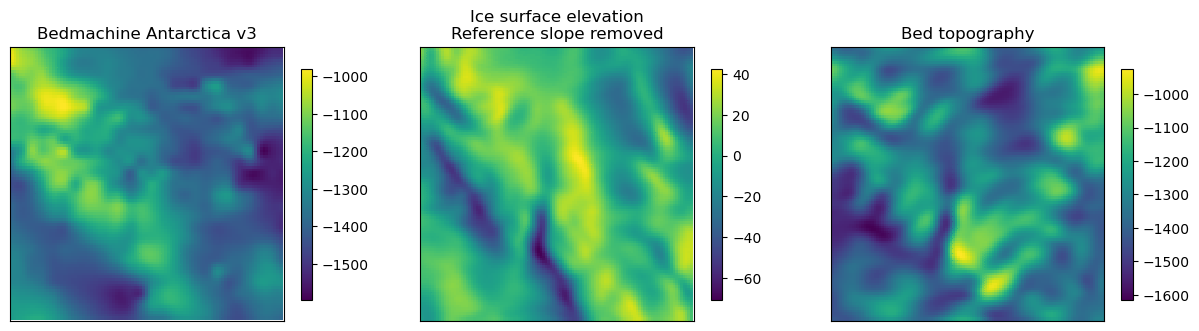

In [21]:
fig, ax = plt.subplots(1,3,figsize = (15,5))
im = [[],[],[]]
titles = ['Bedmachine Antarctica v3', 'Ice surface elevation\nReference slope removed','Bed topography']
im[1] = ax[1].pcolor(X_rema, Y_rema, SURF_interp)
im[0] = ax[0].pcolor(X_bedmach, Y_bedmach, bed)
im[2] = ax[2].pcolor(X_its,Y_its, B_ift.real)

for i in range(3):
    plt.colorbar(im[i], ax = ax[i], shrink = 0.6)
    ax[i].set_title(titles[i], fontsize = 12)
    groundinglineM.plot(ax = ax[i], facecolor = 'None', edgecolor='k', zorder = 0)
    ax[i].get_xaxis().set_ticks([]); ax[i].get_yaxis().set_ticks([]);   
    ax[i].set_xlim(bounds[0], bounds[1])
    ax[i].set_ylim(bounds[2], bounds[3])

To avoid edge effects from the Fourier transform, we only use the central 50% of this grid

In [22]:
width_x = square_size/2 #* adj[0] / (n * centre_include)
width_y = square_size/2 #* adj[1] / (n * centre_include)
outer_X_min = centre_coord[0] - width_x/2
outer_X_max = centre_coord[0] + width_x/2
outer_Y_min = centre_coord[1] - width_y/2
outer_Y_max = centre_coord[1] + width_y/2
xl = next(x for x, val in enumerate(X_its[0,:])\
                       if val >= outer_X_min) 
xh = next(x for x, val in enumerate(X_its[0,:])\
                       if val >= outer_X_max)
yl = next(x for x, val in enumerate(Y_its[:,0])\
                       if val <= outer_Y_max) 
yh = next(x for x, val in enumerate(Y_its[:,0])\
                       if val <= outer_Y_min)
B_ret = B_ift.real[yl:yh,xl:xh]
C_ret = C_ift.real[yl:yh,xl:xh]
X2_ret = X_its[yl:yh,xl:xh]
Y2_ret = Y_its[yl:yh,xl:xh]

In [23]:
bounds = [np.min(X2_ret), np.max(X2_ret), np.min(Y2_ret), np.max(Y2_ret)]

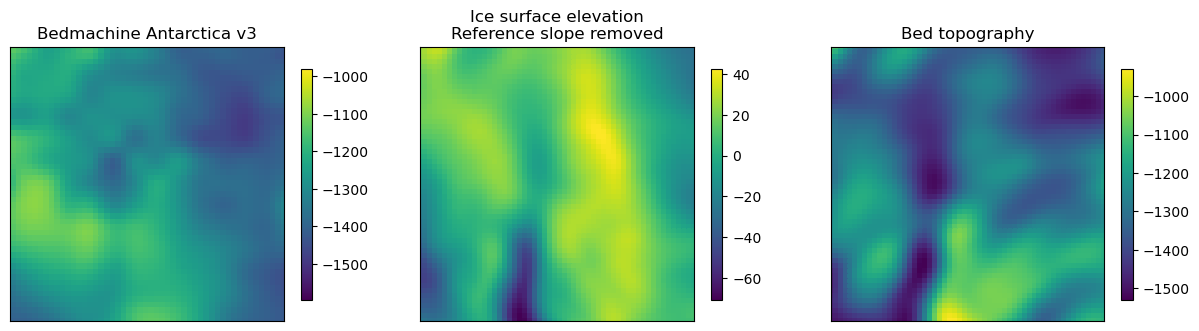

In [24]:
fig, ax = plt.subplots(1,3,figsize = (15,5))
im = [[],[],[]]
titles = ['Bedmachine Antarctica v3', 'Ice surface elevation\nReference slope removed','Bed topography']
im[1] = ax[1].pcolor(X_rema, Y_rema, SURF_interp)
im[0] = ax[0].pcolor(X_bedmach, Y_bedmach, bed)
im[2] = ax[2].pcolor(X2_ret,Y2_ret, B_ret)

for i in range(3):
    plt.colorbar(im[i], ax = ax[i], shrink = 0.6)
    ax[i].set_title(titles[i], fontsize = 12)
    groundinglineM.plot(ax = ax[i], facecolor = 'None', edgecolor='k', zorder = 0)
    ax[i].get_xaxis().set_ticks([]); ax[i].get_yaxis().set_ticks([]);   
    ax[i].set_xlim(bounds[0], bounds[1])
    ax[i].set_ylim(bounds[2], bounds[3])

### The IFPA methodology for multiple patches

Finally, we look at applying the IFPA methodology on several overlapping patches, and the process of stitching these all together, which is what the function **terminal_inversion_smooth_frot** does. 

We begin by calculating the central coordinates of all the requested grids

In [25]:
adj = [4,4] # Setting adj to [4,4] here to keep plots reasonable and runtime low

In [26]:
outer_X_min = centre_coord[0] - ((square_size*adj[0])/(n*4))
outer_X_max = centre_coord[0] + ((square_size*adj[0])/(n*4))
outer_Y_min = centre_coord[1] - ((square_size*adj[0])/(n*4))
outer_Y_max = centre_coord[1] + ((square_size*adj[0])/(n*4))
outer_X_min = centre_coord[0] - ((square_size*3)/(n*4))
outer_X_max = centre_coord[0] + ((square_size*3)/(n*4))
outer_Y_min = centre_coord[1] - ((square_size*3)/(n*4))
outer_Y_max = centre_coord[1] + ((square_size*3)/(n*4))

centresx = np.arange(0,(adj[0]+n-1),1) * (square_size/2)/(centre_include *n)
centresx = centresx - (centresx.max() - centresx.min())/2
centresy = np.arange(0,(adj[1]+n-1),1) * (square_size/2)/(centre_include *n)
centresy = centresy - (centresy.max() - centresy.min())/2
centrex, centrey = np.meshgrid(centresx, centresy)
centrex_adj = centre_coord[0]+ centrex
centrey_adj = centre_coord[1] + centrey

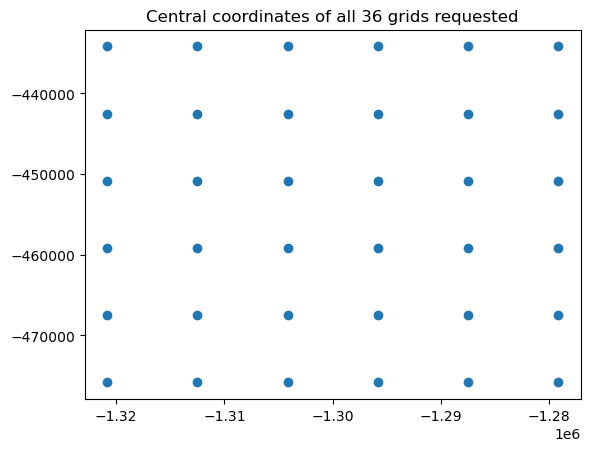

In [27]:
plt.scatter(centrex_adj, centrey_adj)
plt.title('Central coordinates of all {} grids requested'.format((adj[1]+n-1)*(adj[1]+n-1)));

For each of these central coordinates, we repeat the process in the section above to calculate B and C in the region with that central coordinate

In [28]:
import time
import itertools
from inversion_module_v3 import bed_conditions_frot3, smooth_arr, Write_to_nc

In [29]:
# These are the lines which take a long time
# Record start time
start_time = time.time()
X_adjs = np.zeros((centrex_adj.shape[0],centrex_adj.shape[1]), dtype=np.ndarray)
Y_adjs = np.zeros((centrex_adj.shape[0],centrex_adj.shape[1]), dtype=np.ndarray)
B_adjs = np.zeros((centrex_adj.shape[0],centrex_adj.shape[1]), dtype=np.ndarray)
C_adjs = np.zeros((centrex_adj.shape[0],centrex_adj.shape[1]), dtype=np.ndarray)
print('Starting Inversion now')
#for i,j in itertools.product(range(adj[0]),range(adj[1])):
for i,j in itertools.product(range(len(centrex_adj[0])), range(len(centrex_adj[1]))):
    B_adjs[i,j], C_adjs[i,j], X_adjs[i,j], Y_adjs[i,j] = \
    bed_conditions_frot3([centrex_adj[i,j], centrey_adj[i,j]], tapering, n, p_b, p_c, erB, erC, \
                         m, C, square_size, trans_funcs, \
                             filepath_velocity, filepath_rema, filepath_rema_its, filepath_bedmach, interp_grid_spacing, \
                             CutB, CutC, wavcutC, wavcutB)
    if j == len(centrex_adj[1])-1:
        print((i +1) * (j +1),'grids out of',len(centrex_adj[0]) * (j+1),'processed', end='\r')
#print('Ending Inversion now')
# Record end time
end_time = time.time()
# Calculate elapsed time
elapsed_time = end_time - start_time
print(f"Ending Inversion now: {elapsed_time:.4f} seconds")

Starting Inversion now


/Users/ockendeh/Documents/IFPA/Inversion_code/transferfuncs2003.py:22: RuntimeWarning: invalid value encountered in divide
  t27 = ((t1*t6+(1+C+t8*t9)*t5)*m*k)/(m*k*t1*(t5*t6+1+t9*t1)+complex(0,1)*(t6*t3-m)*ca);
/Users/ockendeh/Documents/IFPA/Inversion_code/transferfuncs2003.py:47: RuntimeWarning: invalid value encountered in divide
  t118 = ((complex(0,1)*((3*C*t1*t3-4)*k*t8*C+2*(((4*C+2+t11)*t3+4+4*C)*t7-2*t16)*k)+\
/Users/ockendeh/Documents/IFPA/Inversion_code/transferfuncs2003.py:74: RuntimeWarning: invalid value encountered in divide
  t93 = k*l*(((-t4-4-C)*t3*C*ca+complex(0,1)*(3*t2*t9*t11+2*(4*C+2+t2)*t3-4-4*C)*k)*t18*t20+\
/Users/ockendeh/Documents/IFPA/Inversion_code/transferfuncs2003.py:91: RuntimeWarning: invalid value encountered in divide
  t23 = -C*k*m*t2/(t5*m*k*(t2*t9+1+t11*t5)+complex(0,1)*(t9*t7-m)*ca);
/Users/ockendeh/Documents/IFPA/Inversion_code/transferfuncs2003.py:114: RuntimeWarning: invalid value encountered in divide
  t90 = C*(((t2-2)*t4*ca+complex(0,1)*k*(2*

Ending Inversion now: 9.5175 seconds


We can then look at the bed topography calculated for each of these regions, with the central coordinates as shown in the figure above. Notice that the same features can be seen repeating across different patches, but slightly transposed as the central coordinate of each region is different. 

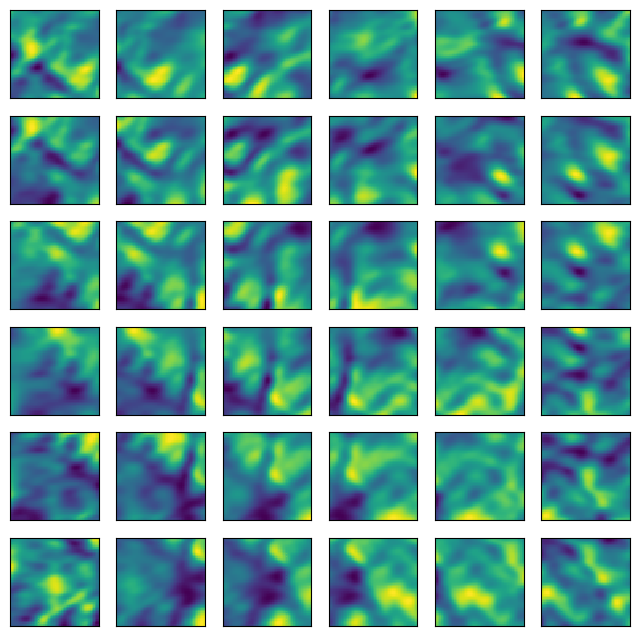

In [30]:
fig, ax = plt.subplots(len(centrex_adj[0]), len(centrex_adj[1]), figsize = (8,8))
for i,j in itertools.product(range(len(centrex_adj[0])), range(len(centrex_adj[1]))):
    ax[len(centrex_adj[0])-1-i,j].pcolor(X_adjs[i,j], Y_adjs[i,j], B_adjs[i,j])
    ax[i,j].get_xaxis().set_ticks([]); ax[i,j].get_yaxis().set_ticks([]);   

We then create the coordinates for the big grid, which encomposes all of these smaller regions

In [31]:
mins_X = np.zeros((centrex_adj.shape[0],centrex_adj.shape[1]))
maxs_X = np.zeros((centrex_adj.shape[0],centrex_adj.shape[1]))
mins_Y = np.zeros((centrex_adj.shape[0],centrex_adj.shape[1]))
maxs_Y = np.zeros((centrex_adj.shape[0],centrex_adj.shape[1]))
for i,j in itertools.product(range(centrex_adj.shape[0]), range(centrey_adj.shape[1])):
    mins_X[i,j] = np.min(X_adjs[i,j])
    maxs_X[i,j] = np.max(X_adjs[i,j])
    mins_Y[i,j] = np.min(Y_adjs[i,j])
    maxs_Y[i,j] = np.max(Y_adjs[i,j])
max_X = np.max(maxs_X)
min_X = np.min(mins_X)
max_Y = np.max(maxs_Y)
min_Y = np.min(mins_Y)
#max_Y = np.max((Y_adjs[0,0].max(), Y_adjs[Y_adjs.shape[0]-1, Y_adjs.shape[0]-1].max()))
#min_Y = np.min((Y_adjs[0,0].min(), Y_adjs[Y_adjs.shape[0]-1, Y_adjs.shape[0]-1].min()))
overall_X = np.arange(min_X, max_X+1, interp_grid_spacing)
overall_Y = np.arange(min_Y, max_Y+1, interp_grid_spacing)
#    overall_Y = np.arange(max_Y, min_Y-1, -interp_grid_spacing)
# Required for the previous dataset where the y coordinates were upside down
big_X, big_Y = np.meshgrid(overall_X, overall_Y)
# Create empty arrays to save the results into 
big_bed = np.zeros((centrex_adj.shape[0],centrex_adj.shape[1]), dtype=np.ndarray)
big_w = np.zeros((centrex_adj.shape[0],centrex_adj.shape[1]), dtype=np.ndarray)
big_slip = np.zeros((centrex_adj.shape[0],centrex_adj.shape[1]), dtype=np.ndarray)
big_bed2 = np.zeros((centrex_adj.shape[0],centrex_adj.shape[1]), dtype=np.ndarray)
big_w2 = np.zeros((centrex_adj.shape[0],centrex_adj.shape[1]), dtype=np.ndarray)
big_slip2 = np.zeros((centrex_adj.shape[0],centrex_adj.shape[1]), dtype=np.ndarray)    

And each sub-region is projected onto the correct part of the larger grid

In [32]:
for i,j in itertools.product(range(centrex_adj.shape[0]), range(centrey_adj.shape[1])):
    length = X_adjs[i,j].shape
    xl = next(x for x, val in enumerate(overall_X)\
                       if val >= (X_adjs[i,j][0,0])) 
    xh = next(x for x, val in enumerate(overall_X)\
                       if val >= (X_adjs[i,j][length[0]-1, length[1]-1]))
    yh = next(x for x, val in enumerate(overall_Y)\
                       if val >= (Y_adjs[i,j][0,0])) 
    yl = next(x for x, val in enumerate(overall_Y)\
                        if val >= (Y_adjs[i,j][length[0]-1, length[1]-1]))
    big_bed[i,j] = np.zeros(big_X.shape)
    big_w[i,j] = np.zeros(big_X.shape)
    big_bed[i,j][yl:yh+1, xl:xh+1] = np.flip(B_adjs[i,j], axis = 0)
    big_w[i,j][yl:yh+1, xl:xh+1] = smooth_arr(B_adjs[i,j])
    #big_w[i,j][big_w[i,j] == 0] = np.nan
    big_slip[i,j] = np.zeros(big_X.shape)
    big_slip[i,j][yl:yh+1, xl:xh+1] = np.flip(C_adjs[i,j], axis = 0) 

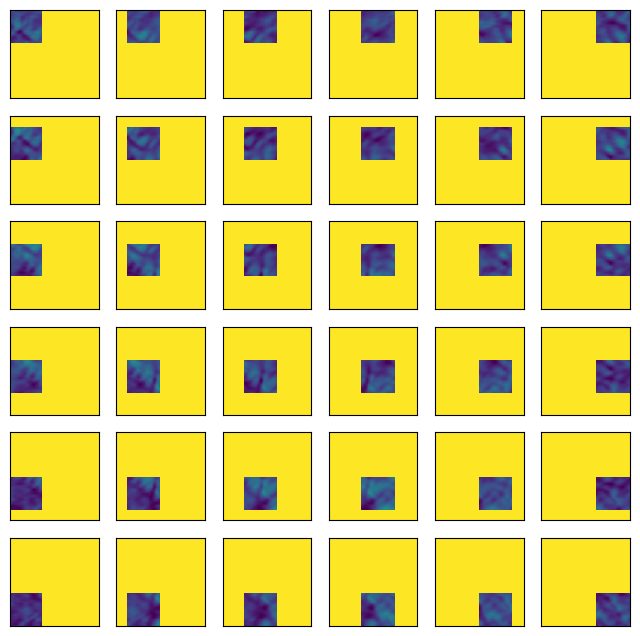

In [44]:
fig, ax = plt.subplots(len(centrex_adj[0]), len(centrex_adj[1]), figsize = (8,8))
for i,j in itertools.product(range(len(centrex_adj[0])), range(len(centrex_adj[1]))):
    ax[len(centrex_adj[0])-1-i,j].pcolor(big_bed[i,j])
    ax[i,j].get_xaxis().set_ticks([]); ax[i,j].get_yaxis().set_ticks([]);   

Finally, we take a weighted sum of each of these larger grids, where the weights are calculated with the function smooth_arr, and represent a sinusoid with value 1 at the centre of the region and value 0 at the edges 

In [34]:
big_w_sum = np.sum(big_w)
big_w_sum[big_w_sum == 0] = np.nan
big_bed_total = np.sum(big_bed * big_w)/big_w_sum
big_slip_total = np.sum(big_slip * big_w)/big_w_sum

We also calculate the standard deviation of the patches which overlap, which gives an indication of the validity of the assumption of planar flow in an inclined slab. (If the flow is perfectly planar then the standard deviation of overlapping regions should be close to zero as the reference slabs in each region will be the same). 
However, the standard deviation doesn't give any indication of the other sources of error in the IFPA method. 

In [46]:
for i,j in itertools.product(range(centrex_adj.shape[0]), range(centrey_adj.shape[1])):
    length = X_adjs[i,j].shape
    xl = next(x for x, val in enumerate(overall_X)\
                       if val >= (X_adjs[i,j][0,0])) 
    xh = next(x for x, val in enumerate(overall_X)\
                       if val >= (X_adjs[i,j][length[0]-1, length[1]-1]))
    yh = next(x for x, val in enumerate(overall_Y)\
                       if val >= (Y_adjs[i,j][0,0])) 
    yl = next(x for x, val in enumerate(overall_Y)\
                        if val >= (Y_adjs[i,j][length[0]-1, length[1]-1]))
    big_bed2[i,j] = np.zeros((big_X.shape)) #* np.nan
    big_w2[i,j] = np.zeros((big_X.shape)) #* np.nan
  #  big_bed2[i,j][yl:yh+1, xl:xh+1] = B_adjs[i,j]
    big_w2[i,j][yl:yh+1, xl:xh+1] = smooth_arr(B_adjs[i,j])
    big_slip2[i,j] = np.zeros((big_X.shape)) #* np.nan
  #  big_slip2[i,j][yl:yh+1, xl:xh+1] = C_adjs[i,j]
    big_bed2[i,j] = np.abs((big_bed[i,j] - big_bed_total)**2)
#    big_bed2[i,j][big_bed[i,j] == 0] = 0
    big_slip2[i,j] =np.abs((big_slip[i,j] - big_slip_total)**2)
#    big_slip2[i,j][big_bed[i,j] == 0] = 0

big_bed2_total = np.sum(big_bed2 * big_w2)/(np.sum(big_w2))
big_bed2_total = np.sqrt(big_bed2_total)
big_slip2_total = np.sum(big_slip2 * big_w2)/(np.sum(big_w2))
big_slip2_total = np.sqrt(big_slip2_total)

To avoid edge effects in the regions where <9 of the calculated patches overlap, we take only the central part of this large grid. 

In [49]:
# Calculate which bit of the grid to include
width_x = square_size/2 * adj[0] / (n * centre_include)
width_y = square_size/2 * adj[1] / (n * centre_include)
outer_X_min = centre_coord[0] - width_x/2
outer_X_max = centre_coord[0] + width_x/2
outer_Y_min = centre_coord[1] - width_y/2
outer_Y_max = centre_coord[1] + width_y/2
xl = next(x for x, val in enumerate(overall_X)\
                       if val >= outer_X_min) 
xh = next(x for x, val in enumerate(overall_X)\
                       if val >= outer_X_max)
yl = next(x for x, val in enumerate(overall_Y)\
                       if val >= outer_Y_min) 
yh = next(x for x, val in enumerate(overall_Y)\
                        if val >= outer_Y_max)
overall_X2 = big_X[yl:yh, xl:xh]
overall_Y2 = big_Y[yl:yh, xl:xh]
overall_bed = big_bed_total[yl:yh,xl:xh]
overall_slip = big_slip_total[yl:yh,xl:xh]
overall_b_std = big_bed2_total[yl:yh,xl:xh]
overall_c_std = big_slip2_total[yl:yh,xl:xh]

# Set output file name and path for this run
filename_this_run = 'GR_002'              
filename = output_folder + filename_this_run + '.nc'

#Save results to file 
Write_to_nc(overall_X2, overall_Y2, overall_bed, overall_bed, overall_b_std, \
            overall_slip, overall_c_std, filename)
print('Results saved to file')
print('Filepath: ', filename)

Results saved to file
Filepath:  ../Notebook_test/GR_002.nc


The results will now be saved in filepath specified above, and we can load them back in to have a look

In [38]:
output = Dataset(filename,'r',format='netCDF4')
X = output.variables['x'][:]
Y = output.variables['y'][:]
x, y = np.meshgrid(X, Y)
bed = output.variables['bed'][:,:]
errbed_j = output.variables['errbed'][:,:]
#slip_j = output.variables['slip'][:,:]
#errslip_j = output.variables['errslip'][:,:]
output.close()

In [39]:
bounds = [np.min(x), np.max(x), np.min(y), np.max(y)]
X_its, Y_its, VX, VY, X_rema, Y_rema, SURF, X_bedmach, Y_bedmach, thick, bedmach, errbed, source = \
        smooth_data_load(bounds, filepath_velocity, filepath_rema, filepath_bedmach)

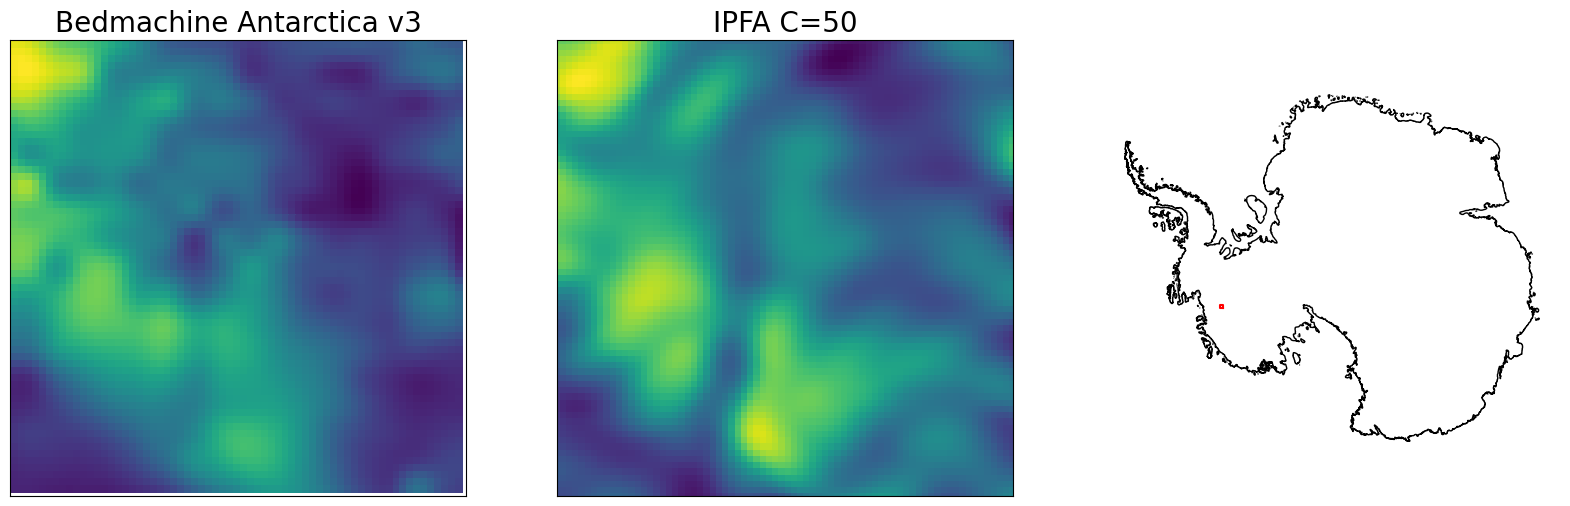

In [40]:
fig, ax = plt.subplots(1,3, figsize = (20,10))
im= [[],[]]
titles = ['Bedmachine Antarctica v3', 'IPFA C={}'.format(C)]
import earthpy.spatial as es
hillshade_on = False
if hillshade_on == True:
    hillshade = es.hillshade(bedmach, altitude = 45, azimuth = 135)
    ax[0].imshow(hillshade, extent = bounds, cmap = 'Greys', zorder = 0, origin = 'upper')
    im[0] = ax[0].imshow(bedmach, extent = bounds, alpha = 0.8, cmap = 'viridis', origin = 'upper')
    hillshade = es.hillshade(bed, altitude = 45, azimuth = 135)
    ax[1].imshow(hillshade, extent = bounds, cmap = 'Greys', zorder = 0, origin = 'lower')
    im[1] = ax[1].imshow(bed, extent = bounds, zorder = 1, alpha = 0.8, origin = 'lower')
else:
    im[0] = ax[0].pcolor(X_bedmach, Y_bedmach, bedmach)
    im[1] = ax[1].pcolor(x, y, bed)
geom = box(bounds[0], bounds[2], bounds[1], bounds[3])
ax[2].plot(*geom.exterior.xy, color = 'r')
ax[2].axis('off')
for i in range(3):
    groundinglineM.plot(ax = ax[i], facecolor = 'None', edgecolor='k', zorder = 0)
    ax[i].get_xaxis().set_ticks([]); ax[i].get_yaxis().set_ticks([]);   
for i in range(2):
    ax[i].set_title(titles[i], fontsize = 20)
    ax[i].set_xlim(bounds[0], bounds[1])
    ax[i].set_ylim(bounds[2], bounds[3])

fig.savefig(output_folder + 'Bed_topography_'+filename_this_run+'.jpg', bbox_inches = 'tight', dpi = 200)